In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as con
import sys
import os

sys.path.append('../..')
import BOPackage

In [2]:
def Ackley(X):
        n = X.shape[1]  # Number of dimensions (should be 20 for this problem)

        # Calculate the objective function value for each row in X
        term1 = -20 * np.exp(-0.2 * np.sqrt(np.sum(X**2, axis=1) / n))
        term2 = -np.exp(np.sum(np.cos(2 * np.pi * X), axis=1) / n)
        y = term1 + term2 + 20 + np.e

        # Make function negative to find the minimum
        y = -y.reshape(-1, 1)

        return y

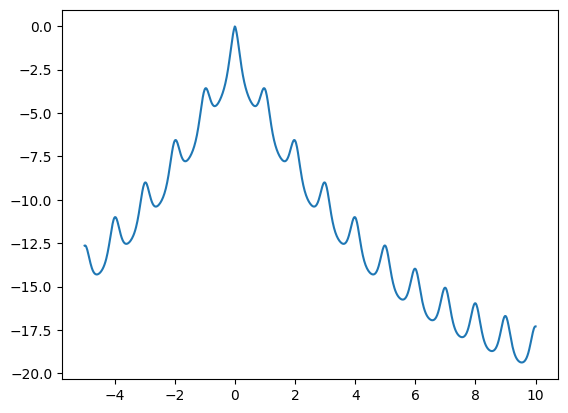

In [3]:
bounds = np.array([[-5, 10]] * 1)

candidate_x = np.linspace(bounds[0,0], bounds[0,1], 1001, endpoint=True).reshape(1001, 1)

result = Ackley(candidate_x)

# Plot the contour
plot = plt.plot(candidate_x, result)

In [4]:
def RunBenchmark(dimensions, length_scale, kappa, acquisition_samples, iterations, images=False):
    bounds = np.array([[-5, 10]] * dimensions)
    ObjectiveFunction = Ackley

    """
    Standard configuration (no batches, no sub-batches, no bounds reduction)
    """

    Kernel = BOPackage.RBF_Kernel
    AcquisitionFunction = BOPackage.UpperConfidenceBound

    random_seed = int(np.random.random() * 1000)

    # Create the object
    bo1 = BOPackage.BO(KernelFunction=Kernel, 
                    length_scale=length_scale, 
                    bounds=bounds, 
                    AcquisitionFunction=AcquisitionFunction, 
                    acquisition_samples=acquisition_samples,
                    random_seed=random_seed)

    raw_X = bo1.GetRandomXBatch(1)
    raw_y = ObjectiveFunction(raw_X)
    bo1.UpdateData(raw_X, raw_y)

    for i in range(iterations):
        raw_X = bo1.GetNextX(kappa=kappa)
        raw_y = ObjectiveFunction(np.array(raw_X))
        bo1.UpdateData(raw_X, raw_y)

    if images:
        BOPackage.PlotData(bo1)

    return random_seed, np.max(bo1.y_data[0:25]), np.max(bo1.y_data[0:50]), np.max(bo1.y_data[0:])

In [ ]:
length_scale = 0.3
kappa = 1
acquisition_samples = 10000
iterations = 100
dimensions = 5
batch_size = 32

bounds = np.array([[-5, 10]] * dimensions)

Kernel = BOPackage.RBF_Kernel
AcquisitionFunction = BOPackage.UpperConfidenceBound

random_seed = int(np.random.random() * 1000)

bo1 = BOPackage.BO(KernelFunction=Kernel, 
                length_scale=length_scale, 
                bounds=bounds, 
                AcquisitionFunction=AcquisitionFunction, 
                acquisition_samples=acquisition_samples,
                random_seed=random_seed)

raw_X = bo1.GetRandomXBatch(256)
raw_y = Ackley(raw_X)
bo1.UpdateData(raw_X, raw_y)

for i in range(1):
    raw_X = bo1.GetNextXBatch(batch_size, kappa=kappa)
    raw_y = Ackley(np.array(raw_X))
    bo1.UpdateData(raw_X, raw_y)

BOPackage.PlotData(bo1, legend=False)

In [11]:
seeds = []
firsts = []
seconds = []
thirds = []

for i in range(1):
    seed, first, second, third = RunBenchmark(dimensions, length_scale=length_scale, kappa=kappa, acquisition_samples=acquisition_samples, iterations=iterations)
    firsts.append(first)
    seconds.append(second)
    thirds.append(third)
    seeds.append(seed)

np.mean(firsts), np.mean(seconds), np.mean(thirds)

(-8.29143027587247, -7.432033840802741, -6.429589102316273)

In [ ]:
"""
1D example of what the code is doing in multiple dimensions.
"""

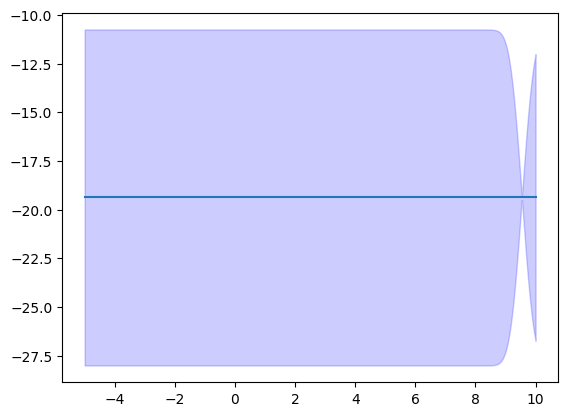

In [5]:
length_scale = 0.4
kappa = 1
acquisition_samples = 100
iterations = 100
dimensions = 1

bounds = np.array([[-5, 10]] * dimensions)

Kernel = BOPackage.RBF_Kernel
AcquisitionFunction = BOPackage.UpperConfidenceBound

random_seed = int(np.random.random() * 1000)

bo1 = BOPackage.BO(KernelFunction=Kernel, 
                length_scale=length_scale, 
                bounds=bounds, 
                AcquisitionFunction=AcquisitionFunction, 
                acquisition_samples=acquisition_samples,
                random_seed=random_seed)

raw_X = bo1.GetRandomXBatch(1)
raw_y = Ackley(raw_X)
bo1.UpdateData(raw_X, raw_y)

mean, variance = bo1.PredictMeanVariance(candidate_x, normalised=False)

plt.plot(candidate_x, mean)
plt.fill_between(candidate_x[:,0], mean[:,0] - 1.96 * np.sqrt(variance[:,0]), mean[:,0] + 1.96 * np.sqrt(variance[:,0]), color = 'blue', alpha=0.2, label = '95% confidence interval')

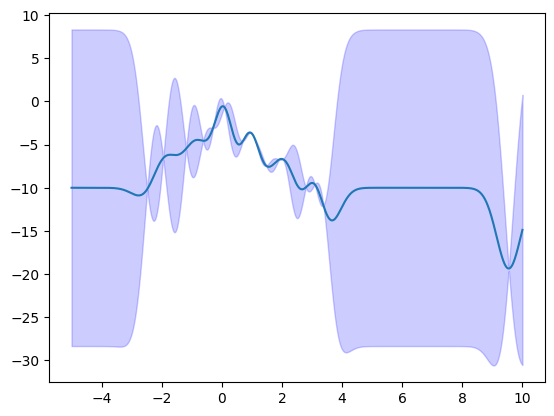

In [9]:
for i in range(10):
    raw_X = bo1.GetNextX(kappa=kappa)
    raw_y = Ackley(np.array(raw_X))
    bo1.UpdateData(raw_X, raw_y)

mean, variance = bo1.PredictMeanVariance(candidate_x, normalised=False)

plt.plot(candidate_x, mean)
plt.fill_between(candidate_x[:,0], mean[:,0] - 1.96 * np.sqrt(variance[:,0]), mean[:,0] + 1.96 * np.sqrt(variance[:,0]), color = 'blue', alpha=0.2, label = '95% confidence interval')

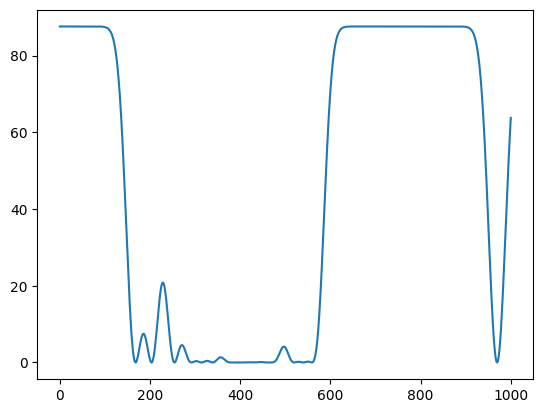

In [10]:
plt.plot(variance)

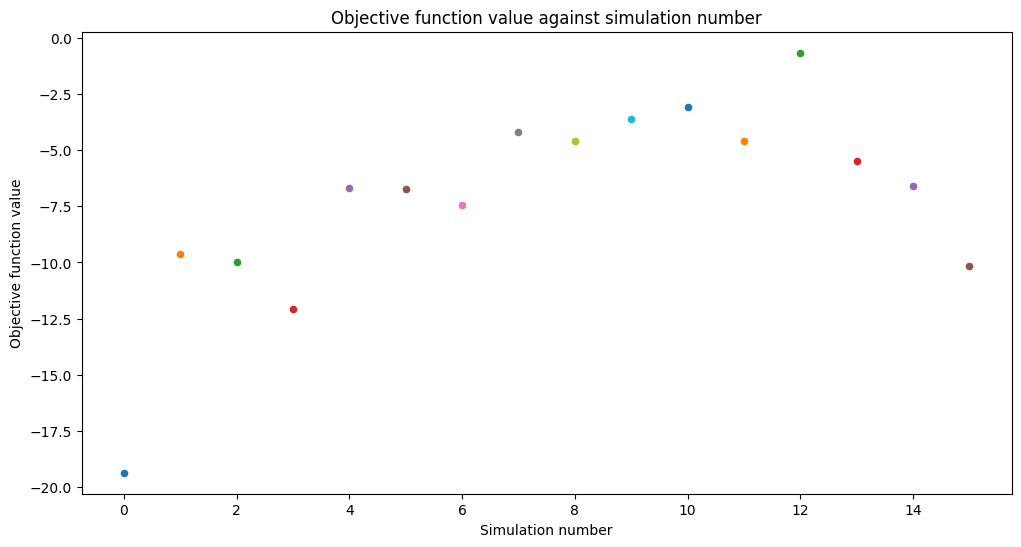

In [11]:
BOPackage.PlotData(bo1, legend=False)